<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/10_ObjectLocalization/TinyImageNet/TinyImageNet_With_Resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries and Install Dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install git+https://github.com/albumentations-team/albumentations.git
!pip install torchsummary
!pip install hiddenlayer
!pip install torch-lr-finder

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-h6y659pr
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-h6y659pr
  Created wheel for albumentations: filename=albumentations-1.0.3-cp37-none-any.whl size=98746 sha256=a921b7fbfb24aac3e345f9cce3e79d5ff0666045b422f1c8a35c8185e71f3210
  Stored in directory: /tmp/pip-ephem-wheel-cache-4376n3g5/wheels/e2/85/3e/2a40fac5cc1f43ced656603bb2fca1327b30ec7de1b1b66517
Successfully built albumentations


In [3]:
!git clone https://github.com/gkdivya/torch_cv_wrapper.git /content/drive/MyDrive/TinyImageNet/session10/torch_cv_wrapper

fatal: destination path '/content/drive/MyDrive/TinyImageNet/session10/torch_cv_wrapper' already exists and is not an empty directory.


In [4]:
%cd "/content/drive/MyDrive/TinyImageNet/session10/"
from __future__ import print_function
import torchvision
import torch
from pprint import pprint
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

## Import Custom Libraries
from torch_cv_wrapper.utils import plot_metrics,train,test,helper
from torch_cv_wrapper.utils.gradcam import generate_gradcam, plot_gradcam
from torch_cv_wrapper.model import resnet18
from torch_cv_wrapper.main import TriggerEngine

/content/drive/MyDrive/TinyImageNet/session10


## Load Config File

In [5]:
config = helper.process_config("/content/drive/MyDrive/TinyImageNet/session10/session10.yaml")
use_cuda = torch.cuda.is_available()
helper.set_seed(config['model_params']['seed'],use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
pprint(config)

 loading Configuration of your experiment ..
{'criterion': 'CrossEntropyLoss',
 'data_augmentation': {'type': 'TinyImageNetAlbumentation'},
 'data_loader': {'args': {'batch_size': 512,
                          'num_workers': 2,
                          'pin_memory': True},
                 'classes': 'None',
                 'type': 'TinyImageNetDataLoader'},
 'lr_finder': {'lr_epochs': 25, 'max_epoch': 5},
 'lr_scheduler': 'OneCycleLR',
 'model': 'Resnet18',
 'model_params': {'dropout': 0.05,
                  'experiment_name': 'TinyImageNet',
                  'model_dir': './model/',
                  'seed': 1},
 'optimizer': {'args': {'lr': 0.01}, 'type': 'optim.SGD'},
 'training_params': {'epochs': 50, 'l1_factor': 0, 'l2_factor': 0.005}}


In [6]:
exp_metrics={}
experiment_name=config['model_params']['experiment_name']
trigger_training=TriggerEngine(config)

## Download Data

In [9]:
# #Get dataloaders
train_loader,test_loader = trigger_training.dataloader()

## View few images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


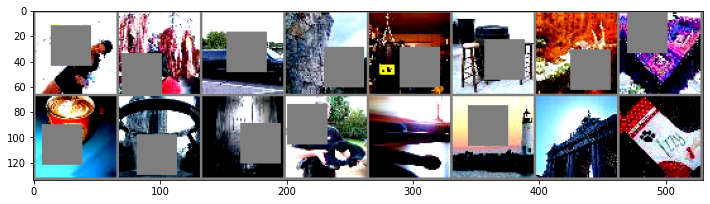

In [10]:
# get some random training images
images, labels = iter(train_loader).next()

# # show images
helper.imshow(torchvision.utils.make_grid(images[:16]))

In [11]:
images[0].shape

torch.Size([3, 64, 64])

## Load the Model

In [12]:
model = resnet18.ResNet18()
model.to(device)
trigger_training.model_summary(model,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

## Visualize Model Architecture

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


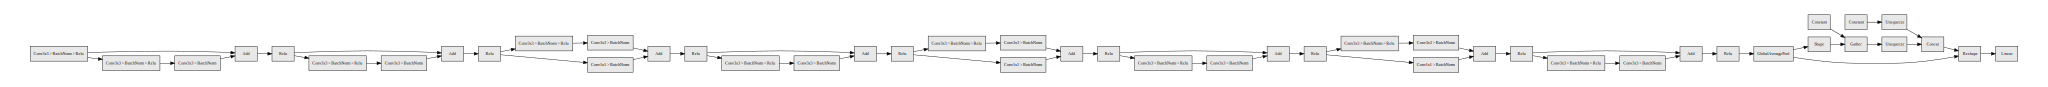

In [13]:
import hiddenlayer as hl
input = torch.zeros([1, 3, 64, 64])
hl.build_graph(model, input.to(device))

## Model Training

In [14]:
trigger_training=TriggerEngine(config)
(exp_metrics[experiment_name]) = trigger_training.run_experiment(model,train_loader,test_loader)

  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1:


Loss=5.039178371429443 Batch_id=150 LR=0.00050 Accuracy=1.79: 100%|██████████| 151/151 [02:14<00:00,  1.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0100, Accuracy: 955/33000 (2.89%)

Epoch 2:


Loss=4.889260768890381 Batch_id=150 LR=0.00082 Accuracy=3.82: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0095, Accuracy: 1519/33000 (4.60%)

Epoch 3:


Loss=4.667901992797852 Batch_id=150 LR=0.00132 Accuracy=6.08: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 2165/33000 (6.56%)

Epoch 4:


Loss=4.299304485321045 Batch_id=150 LR=0.00199 Accuracy=8.36: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 2639/33000 (8.00%)

Epoch 5:


Loss=4.0807647705078125 Batch_id=150 LR=0.00280 Accuracy=11.16: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0081, Accuracy: 4110/33000 (12.45%)

Epoch 6:


Loss=3.909381628036499 Batch_id=150 LR=0.00372 Accuracy=14.06: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0079, Accuracy: 4462/33000 (13.52%)

Epoch 7:


Loss=3.6593008041381836 Batch_id=150 LR=0.00470 Accuracy=16.62: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 5475/33000 (16.59%)

Epoch 8:


Loss=3.4861340522766113 Batch_id=150 LR=0.00571 Accuracy=19.08: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 6106/33000 (18.50%)

Epoch 9:


Loss=3.382807970046997 Batch_id=150 LR=0.00669 Accuracy=21.21: 100%|██████████| 151/151 [02:14<00:00,  1.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 6646/33000 (20.14%)

Epoch 10:


Loss=3.2054648399353027 Batch_id=150 LR=0.00760 Accuracy=23.24: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 6382/33000 (19.34%)

Epoch 11:


Loss=3.277148962020874 Batch_id=150 LR=0.00842 Accuracy=25.16: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 6852/33000 (20.76%)

Epoch 12:


Loss=3.357434034347534 Batch_id=150 LR=0.00909 Accuracy=26.94: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8367/33000 (25.35%)

Epoch 13:


Loss=3.1358141899108887 Batch_id=150 LR=0.00959 Accuracy=28.55: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 7429/33000 (22.51%)

Epoch 14:


Loss=3.132007122039795 Batch_id=150 LR=0.00990 Accuracy=29.98: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8618/33000 (26.12%)

Epoch 15:


Loss=3.0646767616271973 Batch_id=150 LR=0.01000 Accuracy=31.05: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8184/33000 (24.80%)

Epoch 16:


Loss=2.819979190826416 Batch_id=150 LR=0.00998 Accuracy=32.46: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 9176/33000 (27.81%)

Epoch 17:


Loss=2.854982376098633 Batch_id=150 LR=0.00992 Accuracy=33.42: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8584/33000 (26.01%)

Epoch 18:


Loss=2.8824961185455322 Batch_id=150 LR=0.00982 Accuracy=34.53: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 10514/33000 (31.86%)

Epoch 19:


Loss=2.6762936115264893 Batch_id=150 LR=0.00968 Accuracy=35.84: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 9873/33000 (29.92%)

Epoch 20:


Loss=2.628525972366333 Batch_id=150 LR=0.00950 Accuracy=36.57: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 9916/33000 (30.05%)

Epoch 21:


Loss=2.796858310699463 Batch_id=150 LR=0.00929 Accuracy=37.60: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 9772/33000 (29.61%)

Epoch 22:


Loss=2.6271579265594482 Batch_id=150 LR=0.00904 Accuracy=38.58: 100%|██████████| 151/151 [02:14<00:00,  1.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 9964/33000 (30.19%)

Epoch 23:


Loss=2.495180368423462 Batch_id=150 LR=0.00876 Accuracy=39.29: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 11340/33000 (34.36%)

Epoch 24:


Loss=2.6782867908477783 Batch_id=150 LR=0.00845 Accuracy=40.18: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 10756/33000 (32.59%)

Epoch 25:


Loss=2.384762763977051 Batch_id=150 LR=0.00812 Accuracy=40.65: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 11008/33000 (33.36%)

Epoch 26:


Loss=2.7046964168548584 Batch_id=150 LR=0.00775 Accuracy=41.85: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 11752/33000 (35.61%)

Epoch 27:


Loss=2.426396608352661 Batch_id=150 LR=0.00737 Accuracy=42.66: 100%|██████████| 151/151 [02:14<00:00,  1.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 12001/33000 (36.37%)

Epoch 28:


Loss=2.693204402923584 Batch_id=150 LR=0.00696 Accuracy=43.41: 100%|██████████| 151/151 [02:14<00:00,  1.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 12882/33000 (39.04%)

Epoch 29:


Loss=2.380800724029541 Batch_id=150 LR=0.00654 Accuracy=44.35: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 12017/33000 (36.42%)

Epoch 30:


Loss=2.4507110118865967 Batch_id=150 LR=0.00611 Accuracy=44.92: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 11986/33000 (36.32%)

Epoch 31:


Loss=2.221646547317505 Batch_id=150 LR=0.00567 Accuracy=45.88: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 13273/33000 (40.22%)

Epoch 32:


Loss=2.328446388244629 Batch_id=150 LR=0.00522 Accuracy=46.59: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 14000/33000 (42.42%)

Epoch 33:


Loss=2.2868967056274414 Batch_id=150 LR=0.00477 Accuracy=47.38: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 13336/33000 (40.41%)

Epoch 34:


Loss=2.1869566440582275 Batch_id=150 LR=0.00433 Accuracy=48.08: 100%|██████████| 151/151 [02:20<00:00,  1.08it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 14466/33000 (43.84%)

Epoch 35:


Loss=1.9477601051330566 Batch_id=150 LR=0.00388 Accuracy=48.86: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 14520/33000 (44.00%)

Epoch 36:


Loss=2.1264209747314453 Batch_id=150 LR=0.00345 Accuracy=49.98: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 14258/33000 (43.21%)

Epoch 37:


Loss=2.370455741882324 Batch_id=150 LR=0.00303 Accuracy=50.88: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 14231/33000 (43.12%)

Epoch 38:


Loss=2.3144478797912598 Batch_id=150 LR=0.00263 Accuracy=51.96: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 14661/33000 (44.43%)

Epoch 39:


Loss=1.9466303586959839 Batch_id=150 LR=0.00224 Accuracy=53.03: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 15406/33000 (46.68%)

Epoch 40:


Loss=1.8512617349624634 Batch_id=150 LR=0.00188 Accuracy=54.23: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 15427/33000 (46.75%)

Epoch 41:


Loss=1.9609229564666748 Batch_id=150 LR=0.00154 Accuracy=55.26: 100%|██████████| 151/151 [02:15<00:00,  1.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 16604/33000 (50.32%)

Epoch 42:


Loss=1.8405309915542603 Batch_id=150 LR=0.00123 Accuracy=56.68: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 15958/33000 (48.36%)

Epoch 43:


Loss=1.9282079935073853 Batch_id=150 LR=0.00095 Accuracy=58.17: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 16658/33000 (50.48%)

Epoch 44:


Loss=1.6847538948059082 Batch_id=150 LR=0.00071 Accuracy=59.66: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 17195/33000 (52.11%)

Epoch 45:


Loss=1.6877981424331665 Batch_id=150 LR=0.00049 Accuracy=61.14: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 17532/33000 (53.13%)

Epoch 46:


Loss=1.6508392095565796 Batch_id=150 LR=0.00032 Accuracy=62.67: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 18017/33000 (54.60%)

Epoch 47:


Loss=1.7327097654342651 Batch_id=150 LR=0.00018 Accuracy=63.73: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 18244/33000 (55.28%)

Epoch 48:


Loss=1.6093392372131348 Batch_id=150 LR=0.00008 Accuracy=65.15: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 18356/33000 (55.62%)

Epoch 49:


Loss=1.5940402746200562 Batch_id=150 LR=0.00002 Accuracy=65.88: 100%|██████████| 151/151 [02:14<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 18423/33000 (55.83%)

Epoch 50:


Loss=1.6158671379089355 Batch_id=150 LR=0.00000 Accuracy=66.07: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]



Test set: Average loss: 0.0036, Accuracy: 18445/33000 (55.89%)



## Training and Validation Metrics

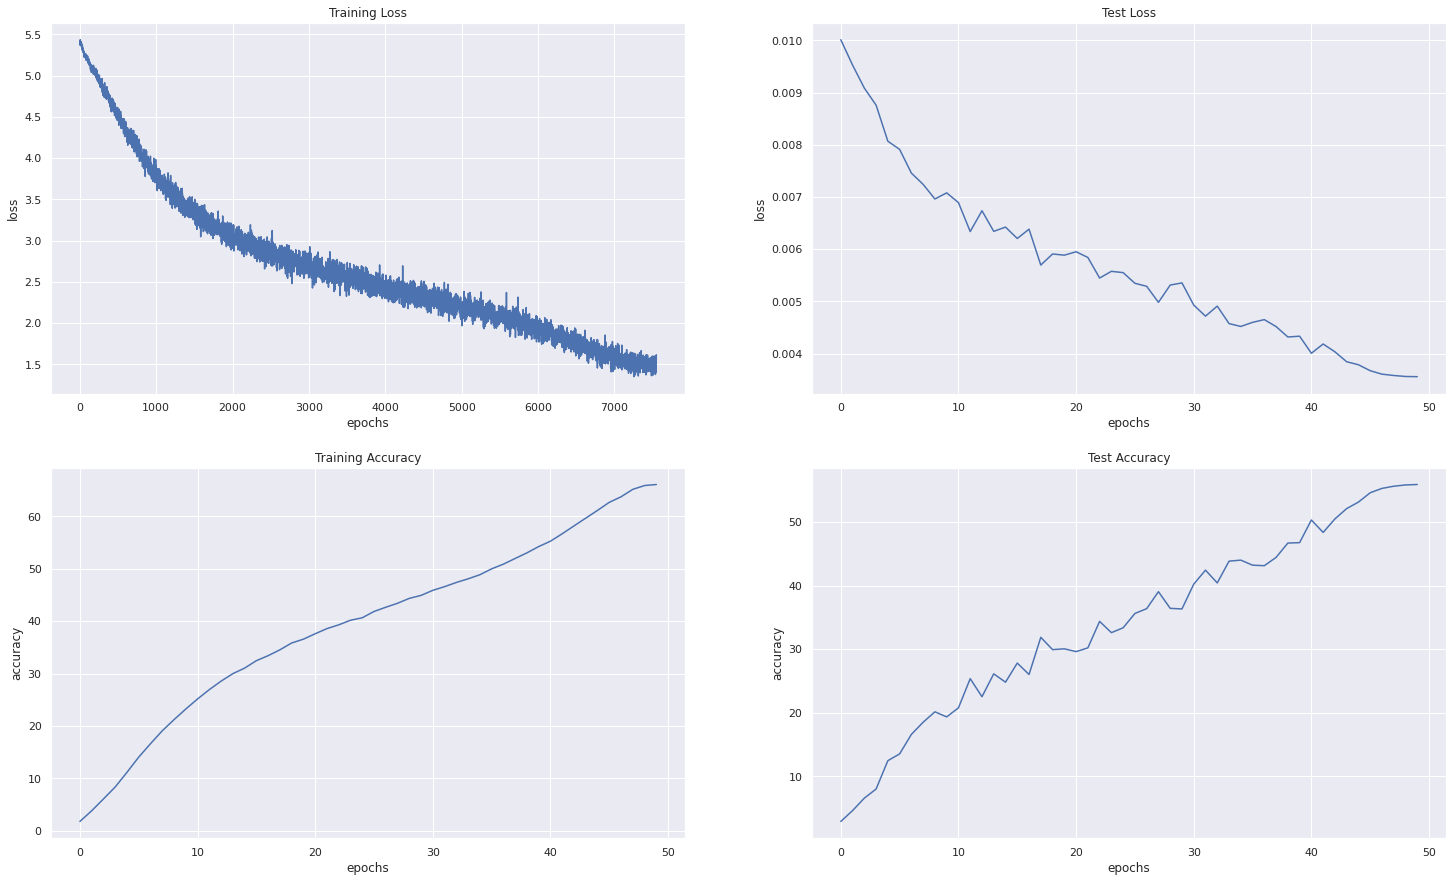

In [15]:
plot_metrics.plot_metrics(exp_metrics[experiment_name])

## Misclassified Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total wrong predictions are 14555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


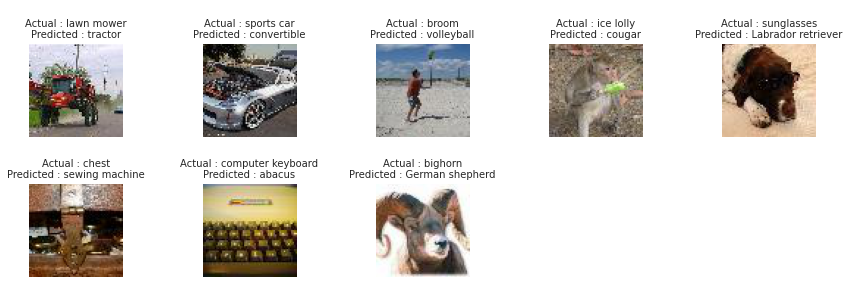

In [31]:
misclassified_images = trigger_training.wrong_predictions(model,test_loader,8)

## Gradcam

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


torch.Size([8, 200])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


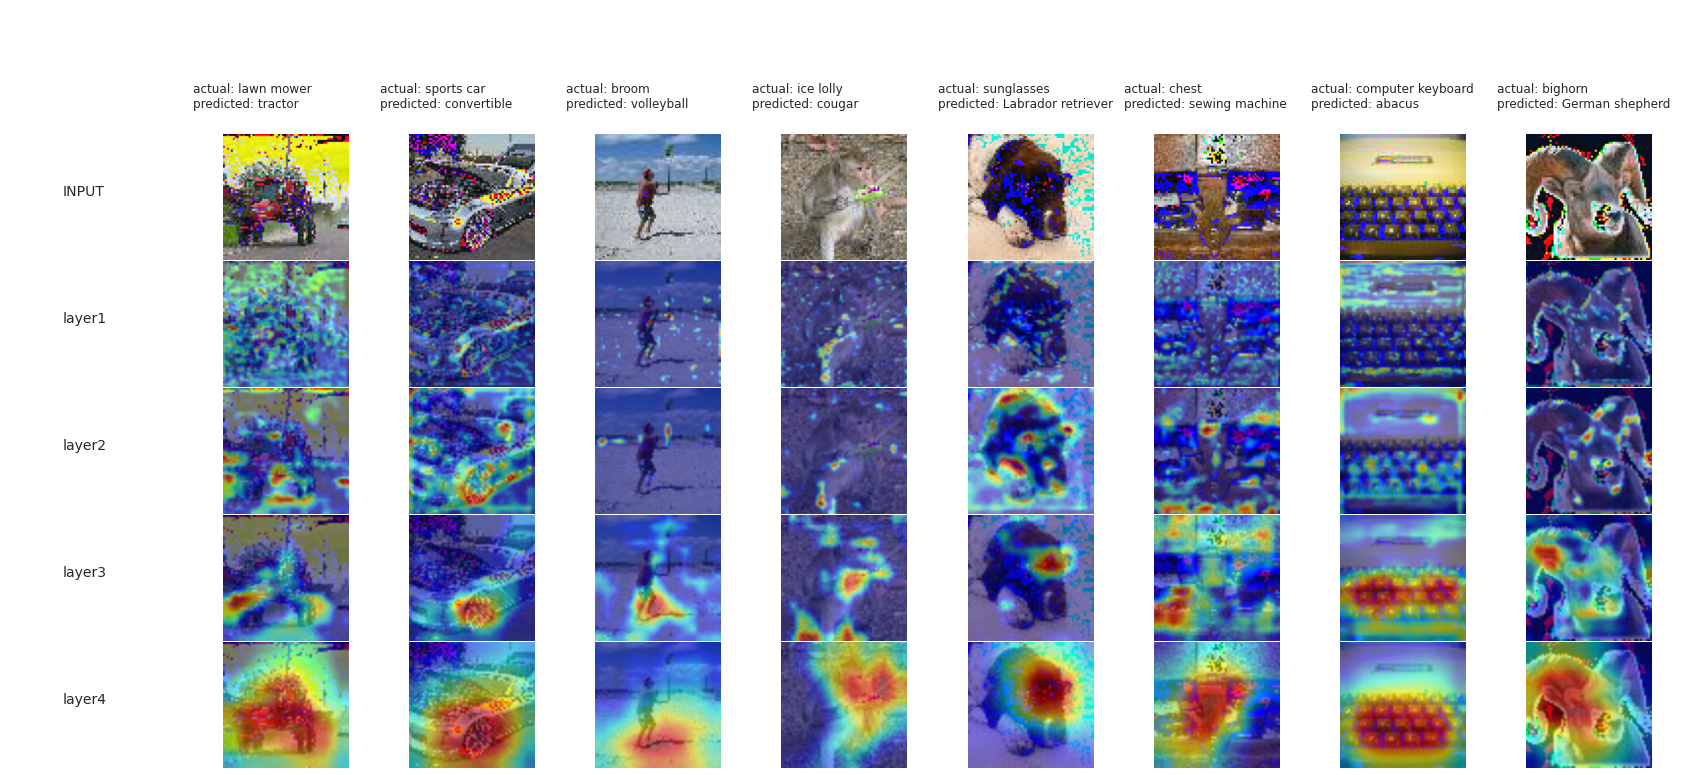

In [34]:
clas_map,_= trigger_training.get_classes()
classes = [x[1] for x in sorted(clas_map.items())]
target_layers = ["layer1","layer2","layer3","layer4"]
gradcam_output, probs, predicted_classes = generate_gradcam(misclassified_images[:8], model, target_layers,device)
plot_gradcam(gradcam_output, target_layers, classes, (3, 64, 64),predicted_classes, misclassified_images[:8])